In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import keras
import matplotlib.pyplot as plt
from IPython import display
from sklearn.utils.class_weight import compute_class_weight
import math

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [3]:
dir = "/Users/justinhickey/tensorflow_datasets/downloads/speech_commands/speech"

train, val = keras.utils.audio_dataset_from_directory(directory=dir, batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')
label_names = np.array(train.class_names)
print()
print("label names:", label_names)

Found 137335 files belonging to 36 classes.
Using 109868 files for training.
Using 27467 files for validation.

label names: ['_background_noise_' 'backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight'
 'five' 'follow' 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left'
 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six'
 'stop' 'three' 'tree' 'two' 'up' 'visual' 'wow' 'yes' 'zero']


Tensor("args_1:0", shape=(None,), dtype=int32)
Tensor("args_1:0", shape=(None,), dtype=int32)
(64, 16000)
(64,)


2024-11-26 15:44:08.929727: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


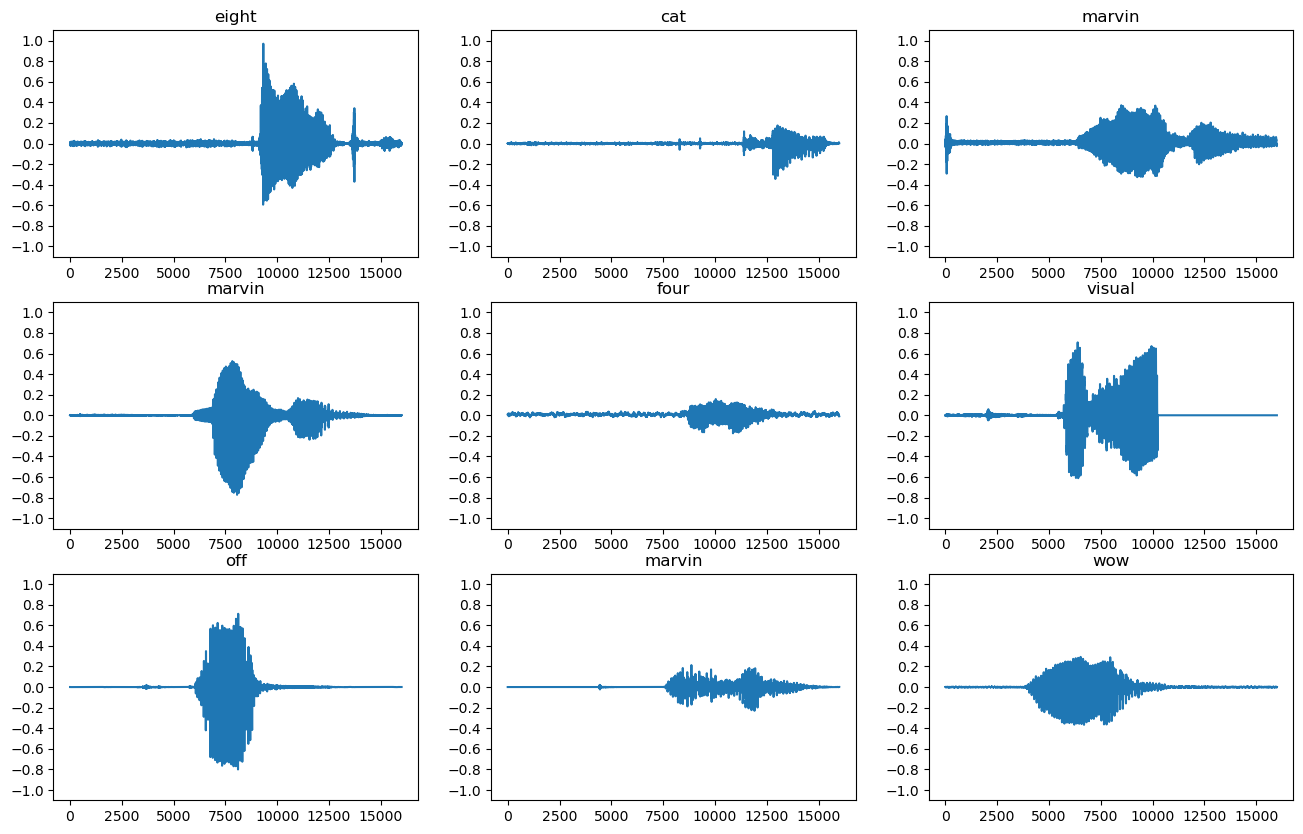

In [4]:
train.element_spec
# single channel audio
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  print(labels)
  return audio, labels

train = train.map(squeeze, tf.data.AUTOTUNE)
val = val.map(squeeze, tf.data.AUTOTUNE)

# make test dataset
test_ds = val.shard(num_shards=2, index=0)
val_ds = val.shard(num_shards=2, index=1)

for example_audio, example_labels in train.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


In [5]:
# convert to spectrogram


def spectrogram(wave):
    # Convert the waveform to a spectrogram via a Short-time fourier transform.
  s = tf.signal.stft(
      wave, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  s = tf.abs(s)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  s = s[..., tf.newaxis]
  return s

for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  s = spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', s.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: eight
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: cat
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: marvin
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [6]:
def map_to_spectrogram(audio, label):
  s = spectrogram(audio)
  string = tf.gather(label_names, label)
  label = tf.where(string == "marvin", 1, 0)
  return s, label

def make_spec_ds(ds):
  return ds.map(
      #map_func=lambda audio,label: (spectrogram(audio), label),
      map_func=map_to_spectrogram,
      num_parallel_calls=tf.data.AUTOTUNE)


train_spectrogram = make_spec_ds(train)
val_spectrogram = make_spec_ds(val_ds)
test_spectrogram = make_spec_ds(test_ds)

class_counts = {}

# Iterate through the dataset and count occurrences of each class
for _, label in train_spectrogram:  # Assuming `train` is your dataset
    label_value = label.numpy() # Convert label to numpy
    for i in range(len(label_value)):
        if label_value[i] in class_counts:
            class_counts[label_value[i]] += 1
        else:
            class_counts[label_value[i]] = 1

print(class_counts)

total_samples = sum(class_counts.values())

# Number of classes
num_classes = len(class_counts)

print("Total samples:", total_samples)
print("Number of classes:", num_classes)

# Compute class weights
class_weights = {
    class_id: total_samples / (num_classes * count)
    for class_id, count in class_counts.items()
}
print("Class weights:", class_weights)


{1: 26863, 0: 83005}
Total samples: 109868
Number of classes: 2
Class weights: {1: 2.0449689163533487, 0: 0.6618155532799229}


2024-11-26 15:44:25.131542: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


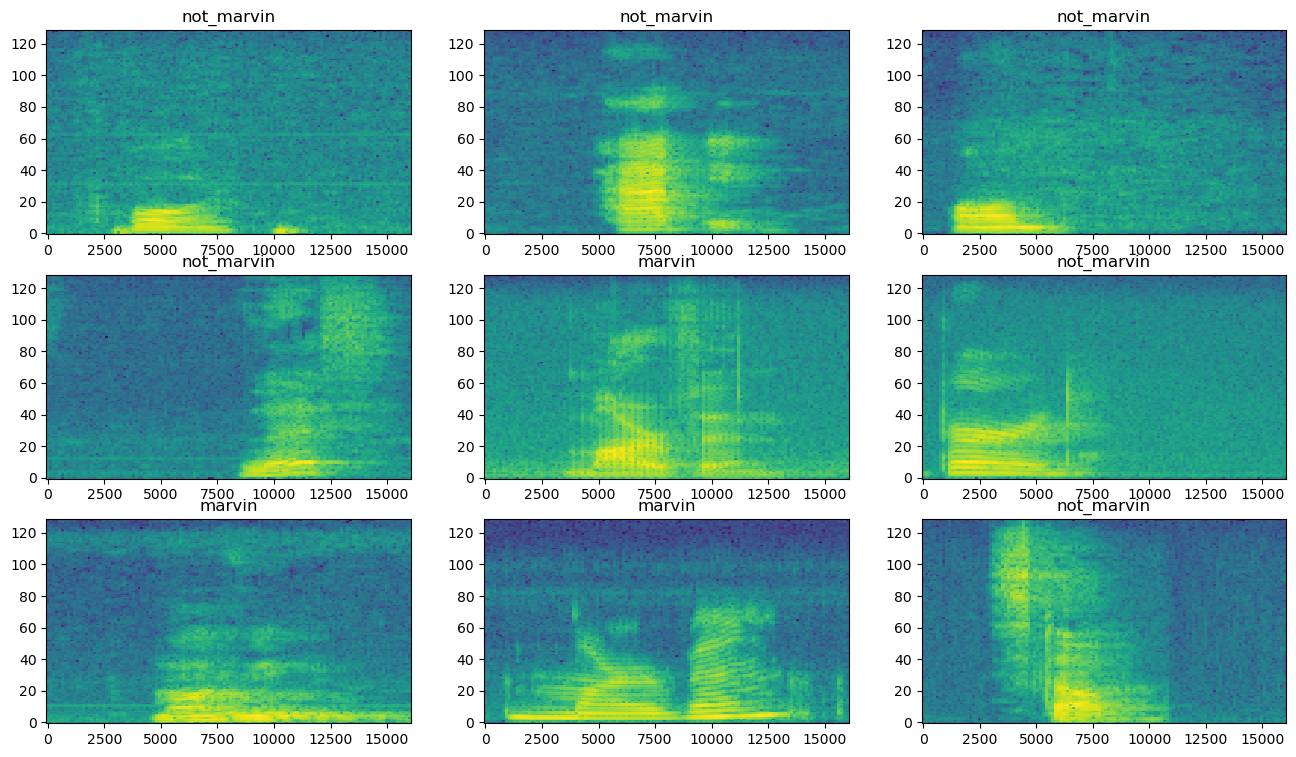

In [7]:



# train_spectrogram_ds = train_spectrogram.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
# val_spectrogram_ds = val_spectrogram.cache().prefetch(tf.data.AUTOTUNE)
# test_spectrogram_ds = test_spectrogram.cache().prefetch(tf.data.AUTOTUNE)

train_spectrogram_ds = train_spectrogram
val_spectrogram_ds = val_spectrogram
test_spectrogram_ds = test_spectrogram


def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

binary_label_names=["not_marvin", "marvin"]

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(binary_label_names[example_spect_labels[i].numpy()])

plt.show()

In [24]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = keras.models.Sequential([
    keras.layers.Input(shape=input_shape),
    # Downsample the input.
    keras.layers.Resizing(8, 8),
    # Normalize.
    #norm_layer,
    keras.layers.Normalization(),
    keras.layers.Conv2D(6, 3, activation='relu'),
    keras.layers.Conv2D(6, 3, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_7 (Resizing)           │ (None, 8, 8, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_15                │ (None, 8, 8, 1)        │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 6, 6, 6)        │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 4, 4, 6)        │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 6)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │           500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 914 (3.57 KB)

 Trainable params: 911 (3.56 KB)

 Non-trainable params: 3 (16.00 B)

In [237]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()],
)

In [241]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    class_weight=class_weights,
)

Epoch 1/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - auc_10: 0.8209 - binary_accuracy: 0.7349 - loss: 0.5246 - precision_8: 0.4785 - recall_8: 0.7753 - val_auc_10: 0.9451 - val_binary_accuracy: 0.8653 - val_loss: 0.3030 - val_precision_8: 0.6698 - val_recall_8: 0.8864
Epoch 2/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - auc_10: 0.9366 - binary_accuracy: 0.8510 - loss: 0.3239 - precision_8: 0.6423 - recall_8: 0.8862 - val_auc_10: 0.9637 - val_binary_accuracy: 0.8972 - val_loss: 0.2381 - val_precision_8: 0.7401 - val_recall_8: 0.8939
Epoch 3/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - auc_10: 0.9533 - binary_accuracy: 0.8752 - loss: 0.2768 - precision_8: 0.6870 - recall_8: 0.9018 - val_auc_10: 0.9695 - val_binary_accuracy: 0.9028 - val_loss: 0.2228 - val_precision_8: 0.7511 - val_recall_8: 0.9013
Epoch 4/10
1717/1717 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - auc_10: 0.9615 - binary_accuracy: 0.8861 - loss: 0.2507 - precision_8: 0.7085 - recall_8: 0.9093 - val_auc_10: 0.9748 - 

In [253]:
#my_dir = "/Users/justinhickey/tensorflow_datasets/downloads/speech_commands/test/marvin/marvin1.wav"
my_dir = "/Users/justinhickey/tensorflow_datasets/downloads/speech_commands/test/"

my_tests = keras.utils.audio_dataset_from_directory(directory=my_dir,
    output_sequence_length=16000,
    batch_size=32,
    shuffle=False,
    )

#.72937196

#0.7234743

my_tests = my_tests.map(squeeze, tf.data.AUTOTUNE)

for x, y in my_tests.take(1):
    print("label:", y.numpy())
    for el in x:
        display.display(display.Audio(el, rate=16000))


my_tests = make_spec_ds(my_tests)

model.save("marvin_model.keras")

model2 = keras.models.load_model("marvin_model.keras")


#model2.evaluate(my_tests)

y_prob = model.predict(my_tests, verbose=2)
print(y_prob)
res = np.round(y_prob)
print(res)

# x = tf.io.read_file(my_dir)
# x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
# x = tf.squeeze(x, axis=-1)
# waveform = x
# x = spectrogram(x)
# x = x[tf.newaxis,...]

# prediction = model(x)
# x_labels = ['no', 'marvin']
# prob = tf.nn.sigmoid(prediction[0])
# print(prob)
# plt.bar(x_labels, [1-prob[0], prob[0]])
# plt.title('No')
# plt.show()

# display.display(display.Audio(waveform, rate=16000))

Found 7 files belonging to 2 classes.
Tensor("args_1:0", shape=(None,), dtype=int32)
label: [0 0 0 1 1 1 1]


2024-11-25 12:51:49.187106: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 - 0s - 86ms/step
[[0.05137356]
 [0.34175074]
 [0.02622151]
 [0.9801222 ]
 [0.98408103]
 [0.9346634 ]
 [0.99280953]]
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [25]:
model.export(".")

INFO:tensorflow:Assets written to: ./assets


INFO:tensorflow:Assets written to: ./assets


Saved artifact at '.'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 124, 129, 1), dtype=tf.float32, name='keras_tensor_75')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  12991056592: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  12980939728: TensorSpec(shape=(1, 1, 1, 1), dtype=tf.float32, name=None)
  5644945360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12980942224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12980935888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12980936656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12980938576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12980930128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12980937808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12980930512: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [26]:
converter2 = tf.lite.TFLiteConverter.from_saved_model(".")
converter2.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

def representative_dataset_gen():
    for input_value, _ in train_spectrogram.take(64):
        yield [input_value]
converter2.representative_dataset = representative_dataset_gen
converter2.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_quant_model = converter2.convert()
open("converted_model.tflite", "wb").write(tflite_quant_model)

W0000 00:00:1732660389.032755  848626 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1732660389.034248  848626 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-11-26 16:33:09.034860: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: .
2024-11-26 16:33:09.035620: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-26 16:33:09.035628: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: .
2024-11-26 16:33:09.043467: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-26 16:33:09.083275: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: .
2024-11-26 16:33:09.094151: I tensorflow/cc/saved_model/loader.cc:462] SavedModel load for tags { serve }; Status: success: OK. Took 57748 microseconds.
fully_quantize: 0, inference_type: 6, input_inference_type: FLOAT32, output_inference_type

5560

In [28]:
!xxd -i converted_model.tflite > model_data.cc